In [1]:
import pandas as pd
from pzflow import Flow
import matplotlib.pyplot as plt
from corner import corner
import numpy as np
import optax

In [2]:
data = pd.read_pickle("../data/dc2.pkl")
data

,redshift,u,g,r,i,z,y,ra,dec,size,ellipticity
0,0.088567,26.408892,25.052967,24.382580,24.054487,23.862051,23.780313,68.140241,-36.593690,0.228518,0.063050
1,1.669109,27.594755,27.341902,26.978935,26.064869,25.297333,24.829222,63.595239,-42.737808,0.157922,0.103562
2,1.159747,25.647858,25.738802,25.805744,25.816053,25.336340,25.312277,65.058580,-34.124349,0.044984,0.077182
3,1.243086,20.772106,20.849342,21.003485,21.068716,20.777245,20.585878,67.102727,-37.531376,0.731108,0.068541
4,0.495375,27.616890,26.316532,25.005684,24.470062,24.259823,24.124353,60.895633,-37.089175,0.136636,0.690425
...,...,...,...,...,...,...,...,...,...,...,...
999995,1.801396,25.059799,24.743279,24.634626,24.544033,24.275795,24.118439,67.129082,-45.451003,0.188007,0.284175
999996,1.704218,25.937052,25.833080,25.912664,25.534258,25.070293,24.750761,62.435367,-39.432315,0.318020,0.093354
999997,0.149601,26.392920,25.087479,24.551336,24.330084,24.194437,24.139854,67.479172,-37.236422,0.411841,0.412781
999998,1.556581,25.935816,25.960798,26.087328,25.866976,25.731079,25.296770,63.362970,-42.674246,0.266826,0.102412


In [144]:
flow = Flow(["redshift"] + list("ugrizy"))

In [145]:
opt = optax.adam(1e-3)
losses = flow.train(data, optimizer=opt, seed=0, verbose=True)

opt = optax.adam(1e-4)
losses += flow.train(data, optimizer=opt, seed=1, verbose=True)

Training 100 epochs 
Loss:
(0) 20.5583
(1) -3.4796
(6) -6.9428
(11) -7.1943
(16) -7.6050
(21) -7.7802
(26) -8.1606
(31) -8.0985
(36) -7.7807
(41) -8.6569
(46) -9.0619
(51) -8.3725
(56) -9.0907
(61) -8.9135
(66) -8.7378
(71) -8.5933
(76) -9.3250
(81) -8.5980
(86) -9.2489
(91) -8.6878
(96) -9.0812
(100) -8.9339
Training 100 epochs 
Loss:
(0) -8.9339
(1) -10.2827
(6) -10.4254
(11) -10.5321
(16) -10.5104
(21) -10.6335
(26) -10.6078
(31) -10.6881
(36) -10.7131
(41) -10.6280
(46) -10.3956
(51) -10.8014
(56) -10.5100
(61) -10.7523
(66) -10.8309
(71) -10.8189
(76) -10.8166
(81) -10.8967
(86) -10.8505
(91) -10.8353
(96) -10.8984
(100) -10.9188


Text(0, 0.5, 'Loss')

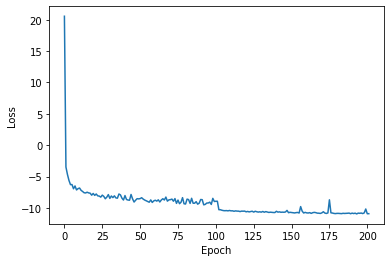

In [146]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [190]:
flow.save("saved-flows/main-flow.pzflow.pkl")

In [3]:
flow = Flow(file="saved-flows/main-flow.pzflow.pkl")

In [8]:
samples = flow.sample(10_000, seed=0)

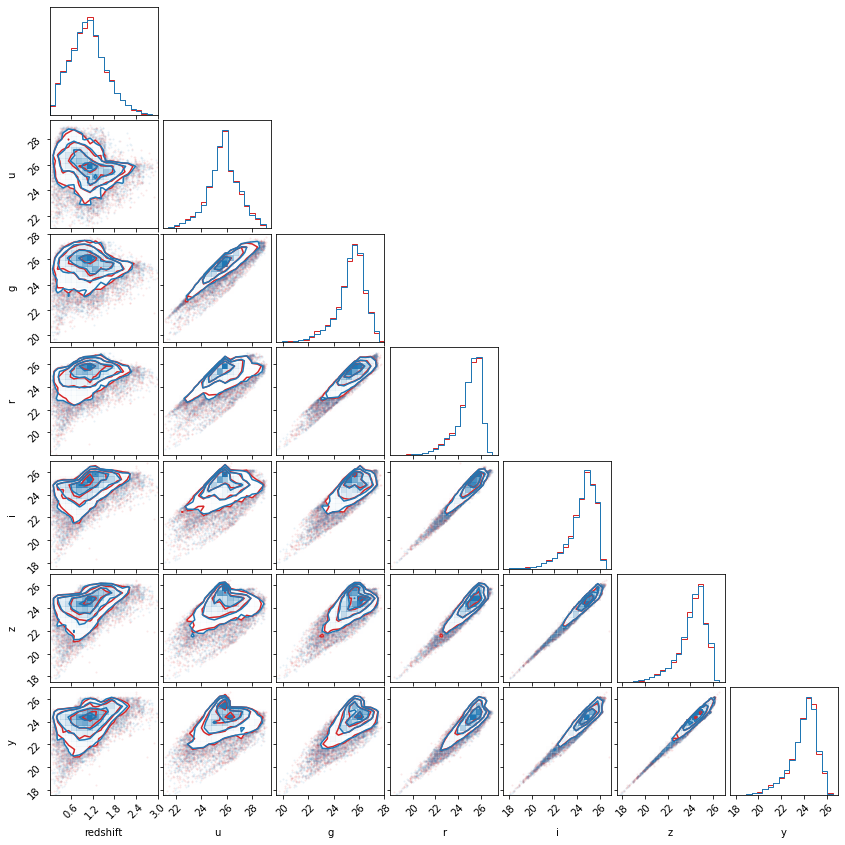

In [9]:
fig = plt.figure(figsize=(12,12))

# global settings for the plot
plot_settings = {
    "fig": fig,
    "range": [
        (0, 3),     # redshift
        (21, 29.5), # u
        (19.5, 28), # g
        (18, 27.5), # r
        (17.5, 27), # i
        (17.5, 27), # z
        (17.5, 27), # y
    ],
    "bins": 20,
    "labels": samples.columns,
}

# plot the data
corner(samples, color="C3", **plot_settings)
corner(data[samples.columns][:samples.shape[0]], color="C0", **plot_settings)

# set the limits on the axes
axes = np.array(fig.axes).reshape(samples.shape[1], -1)
for i, R in enumerate(plot_settings["range"]):
    # set the x limits 
    for ax in axes[:, i]:
        ax.set_xlim(R)
    # set the y limits
    if i > 0:
        for j, ax in enumerate(axes[i]):
            if j < i:
                ax.set_ylim(R)

plt.show()

In [25]:
def quality_cut(sample: pd.DataFrame) -> pd.DataFrame:

    return sample[
        (sample["redshift"] > 0) &
        (sample["u"] - sample["g"] > (data["u"] - data["g"]).min()) &
        (sample["u"] - sample["g"] < (data["u"] - data["g"]).max()) &
        (sample["g"] - sample["r"] > (data["g"] - data["r"]).min()) &
        (sample["g"] - sample["r"] < (data["g"] - data["r"]).max()) &
        (sample["r"] - sample["i"] > (data["r"] - data["i"]).min()) &
        (sample["r"] - sample["i"] < (data["r"] - data["i"]).max()) &
        (sample["i"] - sample["z"] > (data["i"] - data["z"]).min()) &
        (sample["i"] - sample["z"] < (data["i"] - data["z"]).max()) &
        (sample["z"] - sample["y"] > (data["z"] - data["y"]).min()) &
        (sample["z"] - sample["y"] < (data["z"] - data["y"]).max())
    ]

In [26]:
quality_cut(samples).shape[0] / samples.shape[0]

0.9987

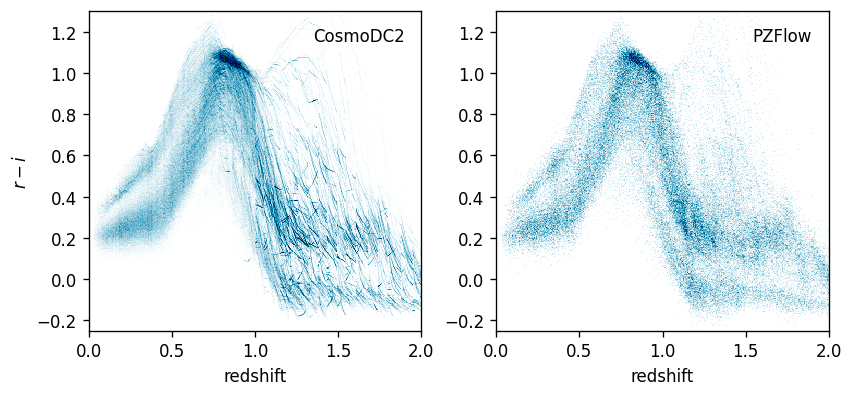

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.2), constrained_layout=True, dpi=120)

plot_settings ={
    "bins": 512,
    "cmap": "ocean_r",
}

samples2 = quality_cut(flow.sample(100_000, seed=0))

ax1.hist2d(data["redshift"], data["r"] - data["i"], **plot_settings)
ax2.hist2d(samples2["redshift"], samples2["r"] - samples2["i"], **plot_settings)

ax1.set(xlim=(0, 2), ylim=(-0.25, 1.3), xlabel="redshift", ylabel="$r - i$")
ax2.set(xlim=(0, 2), ylim=(-0.25, 1.3), xlabel="redshift")

ax1.text(0.95, 0.95, "CosmoDC2", va='top', ha='right', transform=ax1.transAxes)
ax2.text(0.95, 0.95, "PZFlow", va='top', ha='right', transform=ax2.transAxes)

plt.show()